<a href="https://colab.research.google.com/github/hangjoni/ai-notebooks/blob/main/WWF_custom_dataset_with_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up credential for Kaggle

In [ ]:
!pip install kaggle >> /dev/null
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"hangjoni","key":"3d1ff22b3e3113551299c66d7c4bf23a"}'}

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset                Hotel Reservations Dataset                          480KB  2023-01-04 12:50:31           7271        258  1.0              
themrityunjaypathak/most-subscribed-1000-youtube-channels        Most Subscribed 1000 Youtube Channels                28KB  2023-01-21 14:42:05           1334         49  1.0              
senapatirajesh/netflix-tv-shows-and-movies                       Latest Netflix TV shows and movies                    1MB  2023-01-14 17:03:12           2716         72  0.9411765        
ulrikthygepedersen/online-retail-dataset               

# Load dataset from Kaggle

In [ ]:
! kaggle datasets download -d agrigorev/clothing-dataset-full

100% 6.49G/6.50G [00:54<00:00, 162MB/s]
100% 6.50G/6.50G [00:54<00:00, 128MB/s]


In [ ]:
from fastcore.xtras import Path
zip_path = Path("/content/clothing-dataset-full.zip")
zip_path.exists()

True

In [ ]:
import zipfile
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall("content/data")

I missed the / in content/ so we have a weird structure now

In [ ]:
data_path = Path("/content/content/data")
data_path.ls()

(#3) [Path('/content/content/data/images.csv'),Path('/content/content/data/images_compressed'),Path('/content/content/data/images_original')]

In [ ]:
from fastai.vision.all import *

In [ ]:
(data_path/"images_compressed").ls()[:3]

(#3) [Path('/content/content/data/images_compressed/9ff58614-1b66-417d-9fd5-cd929425d03b.jpg'),Path('/content/content/data/images_compressed/65de18e9-ce72-4a7f-9ec8-6f27af98bb76.jpg'),Path('/content/content/data/images_compressed/3c493c1b-85c2-47e6-b6a1-75f8d02304c3.jpg')]

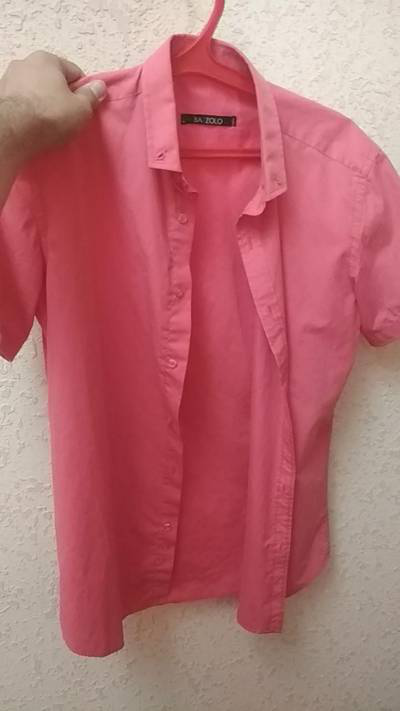

In [ ]:
im_path = (data_path/"images_compressed").ls()[80]
im = Image.open(im_path)
im

In [ ]:
im.shape

(711, 400)

# Corrupted data

In [ ]:
bad_imgs = []
for im in (data_path/"images_compressed").ls():
  try:
    _ = Image.open(im)
  except:
    bad_imgs.append(im)
    im.unlink()


In [ ]:
len(bad_imgs)

6

# DataFrame

In [ ]:
df = pd.read_csv(data_path/'images.csv')
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [ ]:
df[df['label']!= 'Not sure'].shape

(5175, 4)

In [ ]:
clean_df=df[~(df['label']=='Not sure')]

In [ ]:
# removing bad image
for img in bad_imgs:
  clean_df = clean_df[clean_df['image'] != img.stem]

In [ ]:
clean_df.shape

(5170, 4)

In [ ]:
clean_df.label.unique(), clean_df.label.nunique()

(array(['T-Shirt', 'Shoes', 'Shorts', 'Shirt', 'Pants', 'Skirt', 'Other',
        'Top', 'Outwear', 'Dress', 'Body', 'Longsleeve', 'Undershirt',
        'Hat', 'Polo', 'Blouse', 'Hoodie', 'Skip', 'Blazer'], dtype=object),
 19)

# DataLoader

In [ ]:
blocks = (ImageBlock, CategoryBlock)

In [ ]:
get_x = ColReader("image", pref=(data_path/"images_compressed"), suff=".jpg")
get_y = ColReader("label")

In [ ]:
item_tfms = [Resize(224)]
batch_tfms =[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]

DataBlock is like a wrapper on a set of data

It organizes, and properly defines how to get x, y from it, what transformation to do on the data

In [ ]:
dblock = DataBlock(
    blocks=blocks,
    get_x=get_x,
    get_y=get_y,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

This is mind-bending. DataLoader is a method called on the DataBlock. Haha

So DataBlock has no reference to the data itself. It just specify how to read and label and transform data

Then it call DataLoader to use its method, and the DataLoader initialize with the source of data, which can be a folder, a DataFrame etc

In [ ]:
dls = dblock.dataloaders(clean_df)

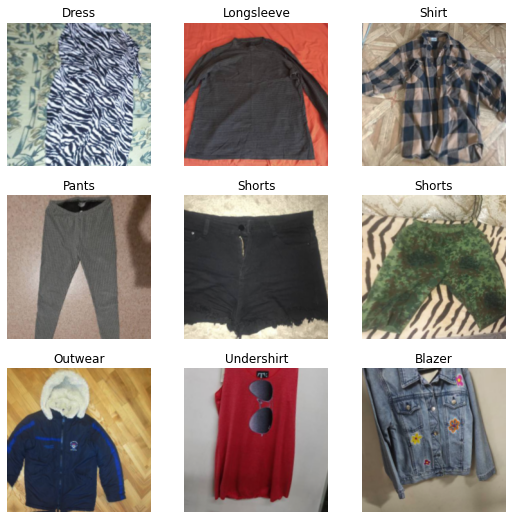

In [ ]:
dls.show_batch()

# Creating a Learner and finetuning

vision_learner load in pretrained weight from the referenced architecture.

fine_tune finetune the model with frozen head for 1 cycle, then unfreeze and train for another x cycles as specified

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.437077,0.964324,0.720503,20:45


epoch,train_loss,valid_loss,accuracy,time
0,1.162912,0.684888,0.810445,30:17
1,0.845181,0.610930,0.835590,29:48
2,0.605950,0.586219,0.848162,29:42


epoch,train_loss,valid_loss,accuracy,time
0,1.162912,0.684888,0.810445,30:17
1,0.845181,0.610930,0.835590,29:48
2,0.605950,0.586219,0.848162,29:42
